# Director's Impact on Public Opinion

### Import libraries and necessary DataFrames

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
imdb_df4 = pd.read_csv('Data/imdb.title.crew.csv') #movie id | directors id | ...
imdb_df6 = pd.read_csv('Data/imdb.title.ratings.csv') #movie id | Average rating | number of votes
name_df = pd.read_csv('Data/imdb.name.basics.csv') #director id | Name | ...

##### Merge DataFrame imdb_df4  With DataFrame imdb_df6
##### Movie ID | Directors ID --onto-- Movie ID | Average Rating | Number of Votes
The cell below completes a right-merge of imdb_df4 onto imdb_df6 across the shared index 'tconst'. This maintains the director's index and removes the extraneous values from imdb_df6 that don't match up with the director index.

In [3]:
imdb_df10 = imdb_df6.merge(imdb_df4, left_on='tconst', right_on = 'tconst', how = 'right')
print('This is imdb_df10 info:')
imdb_df10.info()
print('This is imdb_df4 info:')
imdb_df4.info()
print('This is imdb_df6 info:')
imdb_df6.info()

This is imdb_df10 info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 146144 entries, 0 to 146143
Data columns (total 5 columns):
tconst           146144 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null float64
directors        140417 non-null object
writers          110261 non-null object
dtypes: float64(2), object(3)
memory usage: 6.7+ MB
This is imdb_df4 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
tconst       146144 non-null object
directors    140417 non-null object
writers      110261 non-null object
dtypes: object(3)
memory usage: 3.3+ MB
This is imdb_df6 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
tconst           73856 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In this cell I am removing the NaN values that would otherwise disrupt the analysis. We also see from above, that the dataframes are not the same size. This will result in a significant number of NaNs. While I have 140,000+ directors in imdb_df4, I only have 73,856 reviews/rankings. Fabricating values to fill the NaN's is a possibility. However, fabricating a summary statistic to represent the missing director's reviews and votes would be inappropriate. This is attributed to the small sample size of each director. Summary statistics would be highly volatile, and would cause more harm than good.

In [4]:
imdb_df10.dropna(subset = ['averagerating'], inplace=True)
imdb_df10.dropna(subset = ['numvotes'], inplace = True)  
imdb_df10.dropna(subset = ['directors'], inplace = True)
imdb_df10.drop(['writers'],inplace = True, axis = 1)

The input below creates a new column called 'pos_reaction'. This is done to better analyse the impact of the number of votes and the review rating. 

In [5]:
imdb_df10['pos_reaction'] = imdb_df10['averagerating'] * imdb_df10['numvotes']

Below, we are grouping by the director, and summing

In [7]:
pos_reaction = pd.DataFrame(imdb_df10.groupby('directors').sum())['pos_reaction']
pos_reaction.index

Index(['nm0000080', 'nm0000095', 'nm0000108', 'nm0000110', 'nm0000118',
       'nm0000123', 'nm0000127', 'nm0000128', 'nm0000136', 'nm0000142',
       ...
       'nm9980615', 'nm9982663', 'nm9984798',
       'nm9985563,nm9721180,nm10121042,nm10526486,nm5487558,nm10334170,nm9406188,nm9080058,nm8819942,nm7915159,nm10526485',
       'nm9985845,nm9985846', 'nm9986784', 'nm9987728',
       'nm9988436,nm6041686,nm3591496', 'nm9992853,nm9992852', 'nm9992905'],
      dtype='object', name='directors', length=51151)

In [8]:
directors, counts = np.unique(imdb_df10['directors'], return_counts=True)

dir_pos = {}
for director, count in zip(directors, counts):
    dir_pos[director] = ((pos_reaction.loc[director])/count) #gets the total pos_reaction / count of films made 

In [9]:
top_10_directors = pd.DataFrame(list(dir_pos.items()), columns=['directors', 'avg_positive_reaction'])
top_10_directors.head()

,directors,avg_positive_reaction
0,nm0000080,31167.300
1,nm0000095,759245.975
2,nm0000108,726711.650
3,nm0000110,1529239.040
4,nm0000118,214407.200


In [10]:
top_10_directors = top_10_directors.sort_values('avg_positive_reaction', ascending = False).head(10).reset_index()

In [12]:
def split_column(dir_str):
    mk_split = dir_str.split(',')
    try:
        return mk_split[1]
    except:
        return ''

In [13]:
top_10_directors['director1'] = top_10_directors['directors'].apply(lambda x: x.split(',')[0])
top_10_directors['director2'] = top_10_directors['directors'].apply(split_column)
top_10_directors.head(10)

,index,directors,avg_positive_reaction,director1,director2
0,7622,nm0634240,1.067972e+07,nm0634240,
1,18805,nm1783265,6.566776e+06,nm1783265,
2,438,nm0004306,6.325371e+06,nm0004306,
3,10404,nm0881279,5.662409e+06,nm0881279,
4,8989,"nm0761498,nm0213450",4.951522e+06,nm0761498,nm0213450
5,10853,nm0923736,4.852477e+06,nm0923736,
6,8862,"nm0751577,nm0751648",4.833245e+06,nm0751577,nm0751648
7,62,nm0000399,4.523357e+06,nm0000399,
8,3075,"nm0230032,nm0215455",4.396684e+06,nm0230032,nm0215455
9,608,nm0009190,3.984295e+06,nm0009190,


In [14]:
name_df = pd.read_csv('Data/imdb.name.basics.csv')
#name_df['director1'] = name_df['nconst']
#name_df['director2'] = name_df['nconst']
name_df['name_directors'] = name_df['primary_name']

In [15]:
name_df.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,name_directors
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",Mary Ellen Bauder
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940",Joseph Bauer
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898",Bruce Baum
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387",Axel Baumann
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256",Pete Baxter


In [16]:
top_10_directors.head()

,index,directors,avg_positive_reaction,director1,director2
0,7622,nm0634240,10679723.7,nm0634240,
1,18805,nm1783265,6566776.0,nm1783265,
2,438,nm0004306,6325371.0,nm0004306,
3,10404,nm0881279,5662409.4,nm0881279,
4,8989,"nm0761498,nm0213450",4951521.9,nm0761498,nm0213450


In [17]:
top_10_directors_names = top_10_directors.merge(name_df, left_on = 'director1', right_on = 'nconst', how = 'left')
top_10_directors_names.head(10)


,index,directors,avg_positive_reaction,director1,director2,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,name_directors
0,7622,nm0634240,1.067972e+07,nm0634240,,nm0634240,Christopher Nolan,1970.0,NaN,"writer,producer,director","tt0482571,tt1375666,tt5013056,tt0154506",Christopher Nolan
1,18805,nm1783265,6.566776e+06,nm1783265,,nm1783265,Tim Miller,NaN,NaN,"director,writer,visual_effects","tt9561862,tt0425410,tt1431045,tt1981115",Tim Miller
2,438,nm0004306,6.325371e+06,nm0004306,,nm0004306,George Miller,1945.0,NaN,"producer,writer,director","tt1392190,tt0079501,tt0082694,tt0366548",George Miller
3,10404,nm0881279,5.662409e+06,nm0881279,,nm0881279,Lee Unkrich,1967.0,NaN,"editorial_department,editor,miscellaneous","tt0120363,tt0435761,tt0266543,tt2380307",Lee Unkrich
4,8989,"nm0761498,nm0213450",4.951522e+06,nm0761498,nm0213450,nm0761498,Chris Sanders,1962.0,NaN,"writer,actor,animation_department","tt0120762,tt0892769,tt0275847,tt0481499",Chris Sanders
5,10853,nm0923736,4.852477e+06,nm0923736,,nm0923736,Joss Whedon,1964.0,NaN,"writer,producer,director","tt0118276,tt0162065,tt0848228,tt1259521",Joss Whedon
6,8862,"nm0751577,nm0751648",4.833245e+06,nm0751577,nm0751648,nm0751577,Anthony Russo,1970.0,NaN,"producer,director,writer","tt1843866,tt4154756,tt3498820,tt4154796",Anthony Russo
7,62,nm0000399,4.523357e+06,nm0000399,,nm0000399,David Fincher,1962.0,NaN,"director,producer,actor","tt1285016,tt2267998,tt0443706,tt0114369",David Fincher
8,3075,"nm0230032,nm0215455",4.396684e+06,nm0230032,nm0215455,nm0230032,Pete Docter,1968.0,NaN,"writer,producer,director","tt0910970,tt2096673,tt1049413,tt0198781",Pete Docter
9,608,nm0009190,3.984295e+06,nm0009190,,nm0009190,J.J. Abrams,1966.0,NaN,"producer,writer,music_department","tt0411008,tt0796366,tt1650062,tt2488496",J.J. Abrams


In [19]:
top_10_directors_names2 = top_10_directors_names.merge(name_df, left_on = 'director2', right_on = 'nconst', how = 'left')

In [21]:
final_df = pd.DataFrame()
final_df['Director_ID'] = top_10_directors_names2['directors']
final_df['Avg_Positive_Reaction'] = top_10_directors_names2['avg_positive_reaction']
final_df['Director_1'] = top_10_directors_names2['primary_name_x']
final_df['Director_2'] = top_10_directors_names2['primary_name_y']
#final_df['Director(s)'] = pd.Series()
final_df['Director(s)'] = final_df['Director_1'] + ', ' + final_df['Director_2']
final_df['Director(s)'].fillna(final_df['Director_1'], inplace = True) 

In [22]:
final_df 

,Director_ID,Avg_Positive_Reaction,Director_1,Director_2,Director(s)
0,nm0634240,1.067972e+07,Christopher Nolan,NaN,Christopher Nolan
1,nm1783265,6.566776e+06,Tim Miller,NaN,Tim Miller
2,nm0004306,6.325371e+06,George Miller,NaN,George Miller
3,nm0881279,5.662409e+06,Lee Unkrich,NaN,Lee Unkrich
4,"nm0761498,nm0213450",4.951522e+06,Chris Sanders,Dean DeBlois,"Chris Sanders, Dean DeBlois"
5,nm0923736,4.852477e+06,Joss Whedon,NaN,Joss Whedon
6,"nm0751577,nm0751648",4.833245e+06,Anthony Russo,Joe Russo,"Anthony Russo, Joe Russo"
7,nm0000399,4.523357e+06,David Fincher,NaN,David Fincher
8,"nm0230032,nm0215455",4.396684e+06,Pete Docter,Ronnie Del Carmen,"Pete Docter, Ronnie Del Carmen"
9,nm0009190,3.984295e+06,J.J. Abrams,NaN,J.J. Abrams


In [23]:
imdb_df10.loc[imdb_df10['directors'] == 'nm0634240']

,tconst,averagerating,numvotes,directors,pos_reaction
8738,tt1345836,8.4,1387769.0,nm0634240,11657259.6
24920,tt0816692,8.6,1299334.0,nm0634240,11174272.4
49039,tt5013056,7.9,466580.0,nm0634240,3685982.0
63498,tt1375666,8.8,1841066.0,nm0634240,16201380.8


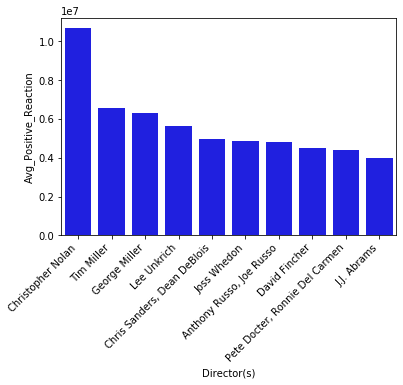

In [24]:
directors = sns.barplot(x= final_df['Director(s)'], y= final_df['Avg_Positive_Reaction'], color= 'blue')
directors.set_xticklabels(directors.get_xticklabels(), rotation=45, ha='right');
